In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import gaussian_filter
import cv2

In [3]:

def visualize(arr: np.array, cmap: str = "viridis", flip: bool = False):
    img = np.copy(arr)
    img = img - img.min()
    img = img / img.max()
    plt.imshow(img, cmap=cmap, origin="upper")


def magnitude2(arrX: np.array, arrY: np.array):
    return np.sqrt(arrX**2 + arrY**2)


def interp2d(a, x, y):
    X = np.floor(x).astype(int)
    Y = np.floor(y).astype(int)
    fracX = x - X
    fracY = y - Y
    X = np.clip(X, 0, a.shape[0] - 2)
    Y = np.clip(Y, 0, a.shape[1] - 2)


    U1 = (1.0 - fracX) * a[X + 0, Y + 0] + fracX * a[X + 1, Y + 0]
    U2 = (1.0 - fracX) * a[X + 0, Y + 1] + fracX * a[X + 1, Y + 1]
    U = (1.0 - fracY) * U1 + fracY * U2
    return U

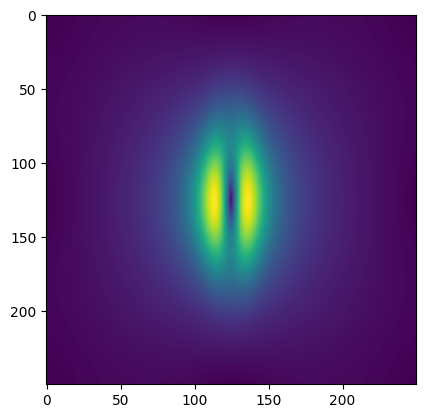

In [4]:
d1 = h5py.File("../metsim1_2d.h5", "r")
u = np.array(d1["Velocity"]["X-comp"]).T
v = np.array(d1["Velocity"]["Y-comp"]).T
u = cv2.resize(u, (250, 250))
v = cv2.resize(v, (250, 250))
mag = magnitude2(u, v).T
img = np.dstack([u, v, np.zeros_like(u)]).T
mesh_size = u.shape[0]
visualize(magnitude2(u, v))

In [5]:
# generate noise texture
n = np.random.random(u.shape)

# perform LIC
l = 2_000
h = np.exp(-np.linspace(-8, 8, l)**2)  

h /= h.sum()
kernel_magnitude = sum(h)

In [6]:
i = np.arange(0, mesh_size).astype(float)
j = np.arange(0, mesh_size).astype(float)
ii, jj = np.meshgrid(i, j)

In [7]:
F = np.zeros_like(n)

F = h[0]*interp2d(n, ii, jj)

step_size = 0.1

# fwd
xx, yy = ii, jj
for k in range(1, l):
    u_local = interp2d(u, xx, yy)
    v_local = interp2d(v, xx, yy)
    mag_local = np.sqrt(u_local**2 + v_local**2) + 1e-6 

    dtx = step_size * u_local / mag_local
    dty = step_size * v_local / mag_local

    xx += dtx
    yy += dty


    F += h[k] * interp2d(n, xx, yy)
    print(f"{k}/{l}")

# bwd
xx, yy = ii, jj
for k in range(1, l):
    u_local = interp2d(u, xx, yy)
    v_local = interp2d(v, xx, yy)
    mag_local = np.sqrt(u_local**2 + v_local**2) + 1e-6  

    dtx = step_size * u_local / mag_local
    dty = step_size * v_local / mag_local

    xx -= dtx
    yy -= dty
    F += h[k] * interp2d(n, xx, yy)
    print(f"{k}/{l}")


1/2000
2/2000
3/2000
4/2000
5/2000
6/2000
7/2000
8/2000
9/2000
10/2000
11/2000
12/2000
13/2000
14/2000
15/2000
16/2000
17/2000
18/2000
19/2000
20/2000
21/2000
22/2000
23/2000
24/2000
25/2000
26/2000
27/2000
28/2000
29/2000
30/2000
31/2000
32/2000
33/2000
34/2000
35/2000
36/2000
37/2000
38/2000
39/2000
40/2000
41/2000
42/2000
43/2000
44/2000
45/2000
46/2000
47/2000
48/2000
49/2000
50/2000
51/2000
52/2000
53/2000
54/2000
55/2000
56/2000
57/2000
58/2000
59/2000
60/2000
61/2000
62/2000
63/2000
64/2000
65/2000
66/2000
67/2000
68/2000
69/2000
70/2000
71/2000
72/2000
73/2000
74/2000
75/2000
76/2000
77/2000
78/2000
79/2000
80/2000
81/2000
82/2000
83/2000
84/2000
85/2000
86/2000
87/2000
88/2000
89/2000
90/2000
91/2000
92/2000
93/2000
94/2000
95/2000
96/2000
97/2000
98/2000
99/2000
100/2000
101/2000
102/2000
103/2000
104/2000
105/2000
106/2000
107/2000
108/2000
109/2000
110/2000
111/2000
112/2000
113/2000
114/2000
115/2000
116/2000
117/2000
118/2000
119/2000
120/2000
121/2000
122/2000
123/2000
1

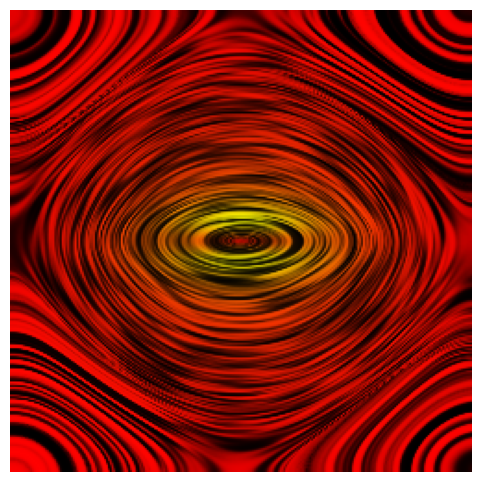

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_facecolor("black")
ax.set_axis_off()

# normalize lic result
F_proc = np.copy(F)
F_proc[mag < 0.01] = 0.0
F_proc -= F_proc.min()
F_proc /= F_proc.max()

# Apply histogram equalization
F_eq = np.copy(F_proc)
F_eq *= 255
F_eq = F_eq.astype(np.uint8)
F_eq = cv2.equalizeHist(F_eq)
F_eq = (F_eq/255.0).astype(np.float32)

mag_proc = np.copy(mag)
mag_proc -= mag_proc.min()
mag_proc /= mag_proc.max()

cmap = plt.cm.autumn(mag_proc)

cmap[..., :3] *= F_eq[..., np.newaxis]
plt.imshow(cmap, cmap='grey')

plt.show()